/tmp/ipykernel_158253/3964341111.py:68: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x, y, '-', color=color, label=label, **kw)
/tmp/ipykernel_158253/3964341111.py:113: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.savefig(f'./plots/NLLScan{res_type}.pdf',bbox_inches='tight')
/tmp/ipykernel_158253/3964341111.py:113: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.savefig(f'./plots/NLLScan{res_type}.pdf',bbox_inches='tight')
/home/pku/zhaoyz/anaconda3/envs/lpr/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


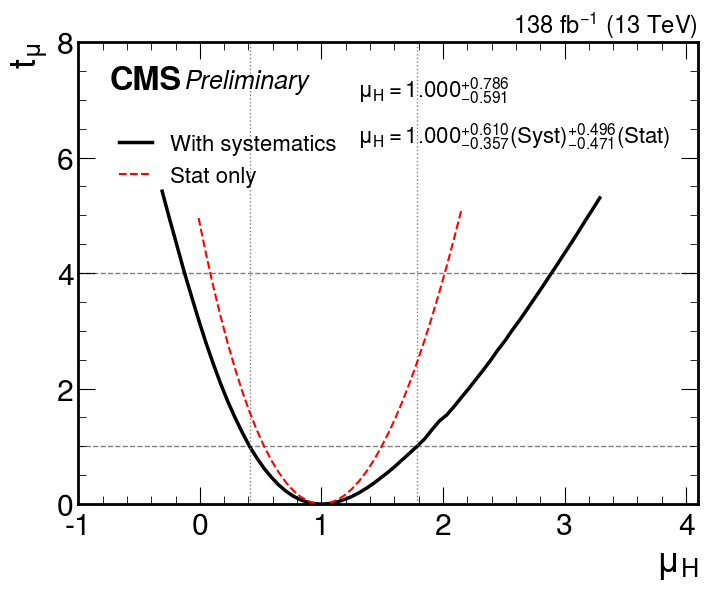

In [64]:
import numpy as np, uproot, matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.optimize import brentq
import math, pathlib

import mplhep as hep
hep.style.use("CMS")

def read_scan(fname, param='r', ycut=7.):
    with uproot.open(fname) as f:
        arr = f['limit'].arrays([param, 'deltaNLL', 'quantileExpected'],
                                cut='quantileExpected>-1.5', library='np')
    x, y = arr[param], 2*arr['deltaNLL']
    m    = y < ycut
    x, y = x[m], y[m]

    # --------去重：对每个 x 只保留 y 最小-----------
    order = np.lexsort((y, x))     # 同 x 时 y 从小到大
    x, y  = x[order], y[order]
    keep  = np.empty_like(x, dtype=bool)
    keep[0] = True
    keep[1:] = x[1:] != x[:-1]     # 仅第一次出现
    x, y = x[keep], y[keep]
    # ----------------------------------------------

    return x, y


from scipy.interpolate import UnivariateSpline
from scipy.optimize    import brentq

def build_spline(x, y, k=3):
    sp = UnivariateSpline(x, y, k=k, s=0)     
    bf = x[np.argmin(y)]                      
    return sp, bf

def find_crossings(sp, ylevel, xgrid):
    """在细网格上定位 y=ylevel 与样条交点，返回 (lo, hi)"""
    f = lambda z: sp(z) - ylevel
    s = sp(xgrid) - ylevel
    sign = np.sign(s)
    # interval
    locs = np.where(np.diff(sign))[0]
    xs   = []
    for i in locs:
        try:
            xs.append(brentq(f, xgrid[i], xgrid[i+1]))
        except ValueError:
            pass
    xs.sort()
    return xs[0], xs[-1]              # lo, hi

import matplotlib.pyplot as plt

def style_tdr(ax):
    ax.set_xlabel(r'$\mu_H$')
    ax.set_ylabel(r'$t_\mu$')
    ax.set_ylim(0, 8)
    ax.set_xlim(*ax.get_xlim())
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in')
    # line
    for y in (1, 4):
        ax.axhline(y, color='grey', lw=1, ls='--', zorder=1)
        
def plot_scan(ax, x, y, label, color, **kw):
    kw.setdefault('lw', 2.5)       # 只有当外部没有设 lw 时才用默认 2.5
    ax.plot(x, y, '-', color=color, label=label, **kw)


def annotate_bestfit(ax, bf, up_tot, dn_tot, up_sys, dn_sys, up_stat, dn_stat, text_left=0.45):
    txt1 = r'$\mu_H = %.3f^{+%.3f}_{%.3f}$' % (bf, up_tot, dn_tot)
    ax.text(text_left, 0.93, txt1, transform=ax.transAxes, fontsize=16, va='top', ha='left')
    
    txt2 = r'$\mu_H = %.3f^{+%.3f}_{%.3f}$(Syst)$^{+%.3f}_{%.3f}$(Stat)' % (bf, up_sys, dn_sys, up_stat, dn_stat)
    ax.text(text_left, 0.83, txt2, transform=ax.transAxes, fontsize=16, va='top', ha='left')
    ax.axvline(bf + dn_tot, color='grey', lw=1, ls=':')
    ax.axvline(bf + up_tot, color='grey', lw=1, ls=':')

# read root files
cards_dir = "./root"
res_type = "Expected"
main_root   = f"{cards_dir}/higgsCombineSnapshot{res_type}.MultiDimFit.mH125.root"
other_root  = f"{cards_dir}/higgsCombine{res_type}freezeAll.MultiDimFit.mH125.root"

x0, y0      = read_scan(main_root, param='r', ycut=5.5)
sp0, bf0    = build_spline(x0, y0)
grid        = np.linspace(x0.min(), x0.max(), 2000)
lo0, hi0    = find_crossings(sp0, 1., grid)

# plot
plt.rcParams['figure.figsize'] = (8,6)
fig, ax = plt.subplots()
style_tdr(ax)

hep.cms.label(loc = 1, data=True,  ax=ax, lumi=138, fontsize=18, llabel='Preliminary')

plot_scan(ax, x0, y0, "With systematics", 'k')

# read from the Combine plots! Not the root file!
# annotate_bestfit(ax, 0.005, 0.626, -0.478, 0.457, -0.28, 0.428, -0.387) # Hard-coded observed res
annotate_bestfit(ax, 1.000, 0.786, -0.591, 0.610, -0.357, 0.496, -0.471) # Hard-coded expected res

# overlay the stat-only scan
x1, y1 = read_scan(other_root, param='r', ycut=5.5)
plot_scan(ax, x1, y1, "Stat‑only", 'r', lw=1.5, ls='--')

# ax.set_xlim(-1.3, 2.3)
ax.set_xlim(-1, 4.1)
ax.legend(loc= "upper left",frameon=False, fontsize = 16, bbox_to_anchor=(0.03, 0.85))


plt.savefig(f'./plots/NLLScan{res_type}.pdf',bbox_inches='tight')

plt.show()
